Portfolio Metrics for the Highest Sharpe Ratio Portfolio:
Number of porfolios analyzed: 1000000
Returns: 26.03%
Risk (Standard Deviation): 19.46%
Sharpe Ratio: 1.19
 
   Symbol  Buy/Sell  CurrentSharePrice  CurrentValue   Shares  TargetValue  ValueAfterAction  SharesAfterAction  TargetSharpeWeight  ActualWeightAfterAction
1    SPYG     -38.0            60.5100       2371.72  39.1955        80.57             72.34             1.1955            1.037842                 0.921016
3    SGDJ     -13.0            27.3000        409.50  15.0000        57.22             54.60             2.0000            0.737111                 0.695154
6     EFV     -11.0            48.2000        735.88  15.2672       197.75            205.68             4.2672            2.547423                 2.618670
5    SPSM      -7.0            36.1900        361.90  10.0000       110.12            108.57             3.0000            1.418590                 1.382288
8     IVE      -7.0           154.0501       170

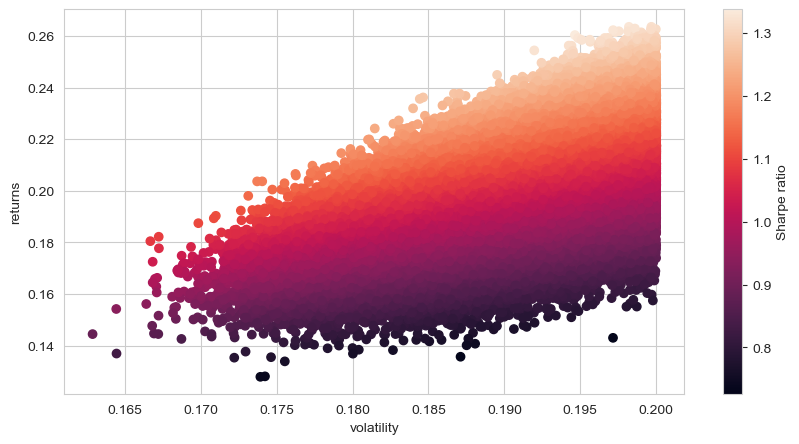

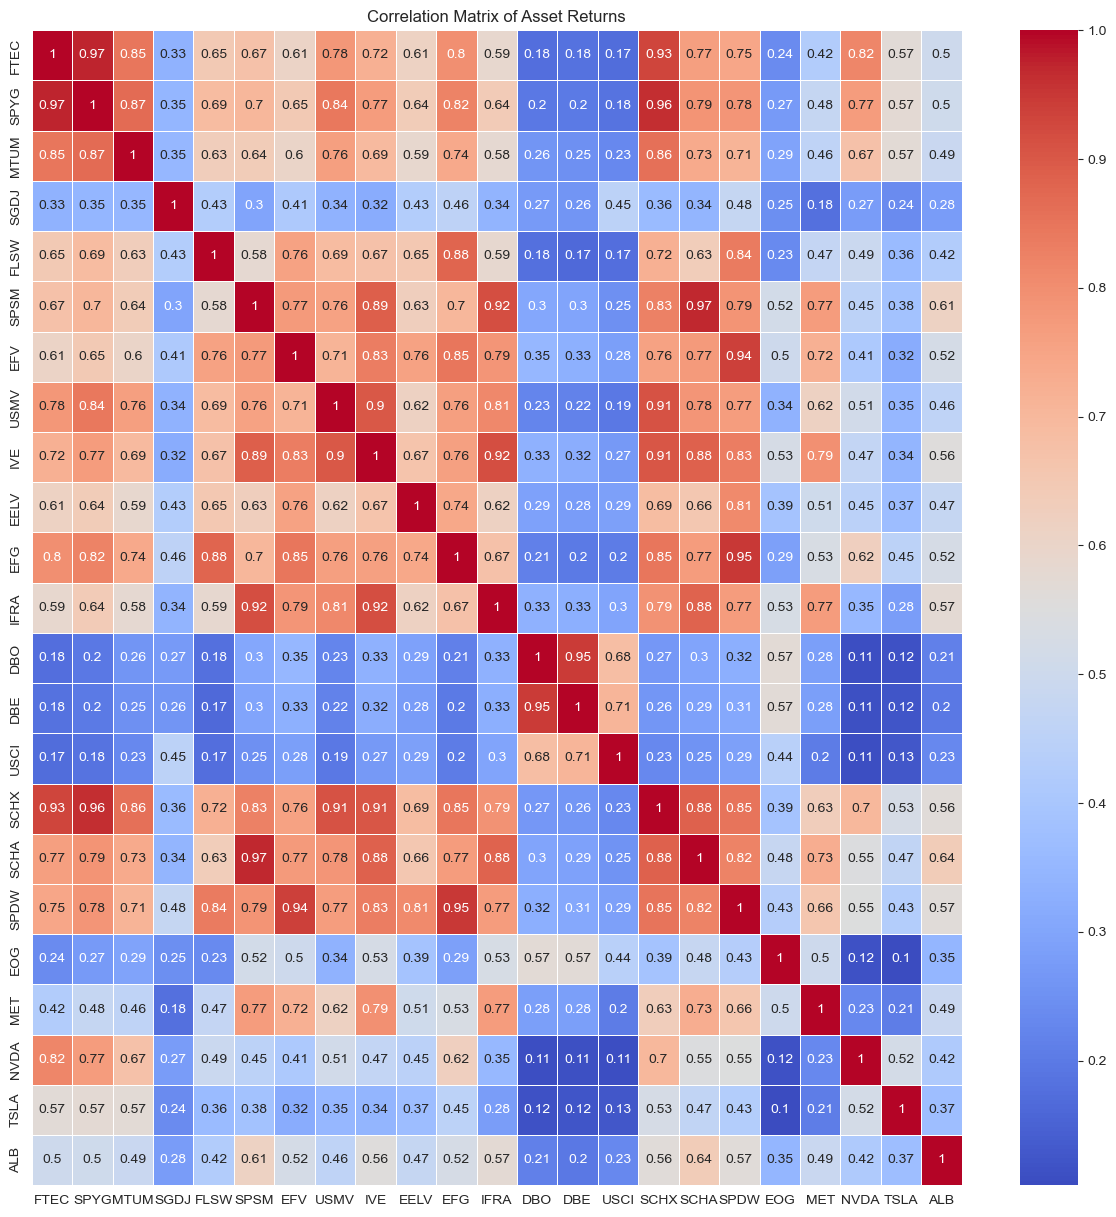

In [19]:
# Standard library imports
import os

# Third-party imports
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from dotenv import load_dotenv

# Load environment variables
load_dotenv()

api_key = os.getenv('FMPKEY')   
STOCKS = [
    'FTEC', 'SPYG', 'MTUM', 'SGDJ', 'FLSW', 'SPSM', 'EFV', 'USMV', 'IVE',
    'EELV', 'EFG', 'IFRA', 'DBO', 'DBE', 'USCI', 'SCHX', 'SCHA', 'SPDW',
    'EOG', 'MET', 'NVDA', 'TSLA', 'ALB'
]
ACCT = 7762.89  # Account balance
RISK = 0.2  # Risk tolerance
RF = 0.0282  # risk free rate 2.82% per annum
NUMBER_OF_PORTFOLIOS = 1000000  # Number of portfolios to simulate

stock_history = {}

# Get all prices into a dataframe
base_url = 'https://financialmodelingprep.com/api/v3/historical-price-full/'
for stock in STOCKS:
    url = f'{base_url}{stock}?serietype=line&apikey={api_key}'
    prices = requests.get(url).json()
    prices_df = pd.DataFrame(prices['historical'])

    # Ensure the data is sorted by date in descending order (most recent first)
    prices_df['date'] = pd.to_datetime(prices_df['date'])
    prices_df = prices_df.sort_values('date', ascending=True)

    # Select the most recent 900 days
    recent_prices = prices_df.tail(900).set_index('date')['close']
    stock_history[stock] = recent_prices

# Concatenate all stock close prices into a single dataframe
portfolio = pd.concat(stock_history, axis=1)

# Calculate daily returns
return_stocks = portfolio.pct_change().dropna()

# Calculate mean returns and covariances of all assets
portfolio_returns = []
portfolio_risk = []
sharpe_ratio_port = []
portfolio_weights = []

for portfolio in range(NUMBER_OF_PORTFOLIOS):
    weights = np.random.random_sample(len(STOCKS))
    weights = weights / np.sum(weights)
    annualize_return = np.sum((return_stocks.mean() * weights) * 252) - RF
    portfolio_returns.append(annualize_return)

    matrix_covariance_portfolio = (return_stocks.cov()) * 252
    portfolio_variance = np.dot(weights.T, np.dot(matrix_covariance_portfolio, weights))
    portfolio_standard_deviation = np.sqrt(portfolio_variance)
    portfolio_risk.append(portfolio_standard_deviation)

    sharpe_ratio = ((annualize_return - RF) / portfolio_standard_deviation)
    sharpe_ratio_port.append(sharpe_ratio)

    portfolio_weights.append(weights)

# Convert lists to arrays outside the loop
portfolio_risk = np.array(portfolio_risk)
portfolio_returns = np.array(portfolio_returns)
sharpe_ratio_port = np.array(sharpe_ratio_port)

# Filtering portfolios by RISK
indices_within_risk = np.where(portfolio_risk <= RISK)[0]

portfolio_risk = portfolio_risk[indices_within_risk]
portfolio_returns = portfolio_returns[indices_within_risk]
sharpe_ratio_port = sharpe_ratio_port[indices_within_risk]
portfolio_weights = np.array(portfolio_weights)[indices_within_risk]

# Create a dataframe with the returns and risk values of each portfolio
plt.figure(figsize=(10, 5))
plt.scatter(portfolio_risk, portfolio_returns, c=portfolio_returns / portfolio_risk)
plt.xlabel('volatility')
plt.ylabel('returns')
plt.colorbar(label='Sharpe ratio')

porfolio_metrics = [portfolio_returns, portfolio_risk, sharpe_ratio_port, portfolio_weights]
portfolio_dfs = pd.DataFrame(porfolio_metrics).T

# Rename the columns:
portfolio_dfs.columns = ['Port Returns', 'Port Risk', 'Sharpe Ratio', 'Portfolio Weights']

# Convert from object to float the first three columns.
for col in ['Port Returns', 'Port Risk', 'Sharpe Ratio']:
    portfolio_dfs[col] = portfolio_dfs[col].astype(float)

highest_sharpe_port = portfolio_dfs.iloc[portfolio_dfs['Sharpe Ratio'].idxmax()]
highest_sharpe_weights = highest_sharpe_port['Portfolio Weights']

#current_portfolio = pd.read_csv('C:/Users/thomas.higginbotham/OneDrive/PortfolioMagic/portfolio.csv')
current_portfolio = pd.read_csv('/Users/thomashigginbotham/Library/CloudStorage/OneDrive-Personal/PortfolioMagic/portfolio.csv')

# Function to compute buy/sell recommendations
def compute_buy_sell_recommendations(current_portfolio, acct, highest_sharpe_weights, stocks, stock_history):
    # Convert weights to desired monetary value in the portfolio
    desired_values = highest_sharpe_weights * acct

    # Get the latest stock prices
    current_prices = {stock: stock_history[stock].iloc[-1] for stock in stocks}

    # Calculate desired shares (decimal value)
    desired_shares_decimal = {
        stock: desired_values[i] / current_prices[stock] for i, stock in enumerate(stocks)}

    # Calculate Buy/Sell (rounded value)
    buy_sell_shares = {stock: (
        desired_shares_decimal[stock]) - current_portfolio[current_portfolio['Symbol'] == stock]['Shares'].values[0] for stock in stocks}

    # Merge current portfolio with desired shares
    merged_portfolio = current_portfolio.merge(pd.DataFrame(
        buy_sell_shares.items(), columns=['Symbol', 'Buy/Sell']), on='Symbol')

    # Calculate other columns
    merged_portfolio['CurrentSharePrice'] = merged_portfolio['Symbol'].map(
        current_prices)
    merged_portfolio['TargetValue'] = merged_portfolio['Symbol'].map(
        {stock: value for stock, value in zip(stocks, desired_values)})
    merged_portfolio['TargetValue'] = merged_portfolio['TargetValue'].round(2)
    merged_portfolio['CurrentValue'] = merged_portfolio['Shares'] * \
        merged_portfolio['CurrentSharePrice']
    merged_portfolio['CurrentValue'] = merged_portfolio['CurrentValue'].round(
        2)
    merged_portfolio['Buy/Sell'] = (merged_portfolio['Buy/Sell']).round(0)
    merged_portfolio['SharesAfterAction'] = merged_portfolio['Shares'] + \
        merged_portfolio['Buy/Sell']
    merged_portfolio['ValueAfterAction'] = merged_portfolio['SharesAfterAction'] * \
        merged_portfolio['CurrentSharePrice']
    merged_portfolio['ValueAfterAction'] = merged_portfolio['ValueAfterAction'].round(
        2)
    merged_portfolio['TargetSharpeWeight'] = merged_portfolio['Symbol'].map(
        {stock: weight for stock, weight in zip(stocks, highest_sharpe_weights)})*100  # Convert to percentage
    merged_portfolio['ActualWeightAfterAction'] = merged_portfolio['ValueAfterAction'] / \
        (merged_portfolio['ValueAfterAction'].sum()) * \
        100  # Convert to percentage

    # Sort dataframe by 'Buy/Sell' column with negative values first
    merged_portfolio = merged_portfolio.sort_values(
        by='Buy/Sell', ascending=True)

    return merged_portfolio[['Symbol', 'Buy/Sell', 'CurrentSharePrice', 'CurrentValue', 'Shares', 'TargetValue', 'ValueAfterAction', 'SharesAfterAction', 'TargetSharpeWeight', 'ActualWeightAfterAction']]


# Set display options
pd.set_option('display.max_columns', None)  # Display all columns
# Display full content of the column
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)  # Display all rows
pd.set_option('display.width', None)  # Width of the display in characters
# Disable wrapping of the info across multiple lines
pd.set_option('display.expand_frame_repr', False)

# Get buy/sell recommendations
recommendations = compute_buy_sell_recommendations(
    current_portfolio, ACCT, highest_sharpe_weights, STOCKS, stock_history)

# Printing the asset symbols along with their respective weights

# Extracting and printing the metrics
print(f"Portfolio Metrics for the Highest Sharpe Ratio Portfolio:")
print(f"Number of porfolios analyzed: {NUMBER_OF_PORTFOLIOS}")
print(f"Returns: {highest_sharpe_port['Port Returns']*100:.2f}%")
print(
    f"Risk (Standard Deviation): {highest_sharpe_port['Port Risk']*100:.2f}%")
print(f"Sharpe Ratio: {highest_sharpe_port['Sharpe Ratio']:.2f}")
print(f' ')
print(recommendations)

# Calculate the correlation matrix
correlation_matrix = return_stocks.corr()

# Visualize the correlation matrix using a heatmap
plt.figure(figsize=(15, 15))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Matrix of Asset Returns")
plt.show()

In [29]:
filtered_recommendations = recommendations[['Symbol', 'SharesAfterAction', 'CurrentSharePrice', 'ValueAfterAction']]
filtered_recommendations = filtered_recommendations.sort_values(by='Symbol')

In [30]:
print(filtered_recommendations)

   Symbol  SharesAfterAction  CurrentSharePrice  ValueAfterAction
22    ALB             2.0000           152.2262            304.45
13    DBE            35.0000            23.3800            818.30
12    DBO            12.0000            17.4998            210.00
9    EELV            29.4160            22.2600            654.80
10    EFG             1.0382            85.1020             88.35
6     EFV             4.2672            48.2000            205.68
18    EOG             3.0000           135.7500            407.25
4    FLSW             6.0000            29.7250            178.35
0    FTEC             0.0072           125.6924              0.90
11   IFRA            23.0252            35.9408            827.54
8     IVE             4.0610           154.0501            625.60
19    MET             2.0000            63.0650            126.13
2    MTUM             1.0059           141.3500            142.18
20   NVDA             2.0000           424.0772            848.15
16   SCHA 